In [12]:
import os
import MySQLdb
from dotenv import load_dotenv
import pandas as pd
load_dotenv()
import plotnine

def database_query(sql_query):
    try:
        connection = MySQLdb.connect(
        host=os.getenv("DATABASE_HOST"),
        user=os.getenv("DATABASE_USERNAME"),
        passwd=os.getenv("DATABASE_PASSWORD"),
        db=os.getenv("DATABASE"),
        autocommit=True,
        # ssl_mode="VERIFY_iDENTITY",
        ssl={"ca": "/etc/ssl/certs/ca-certificates.crt"})
    except:
        connection = MySQLdb.connect(
        host=os.environ["DATABASE_HOST"],
        user=os.environ["DATABASE_USERNAME"],
        passwd=os.environ["DATABASE_PASSWORD"],
        db=os.environ["DATABASE"],
        autocommit=True,
        # ssl_mode="VERIFY_iDENTITY",
        ssl={"ca": "/etc/ssl/certs/ca-certificates.crt"})
    try:
        c = connection.cursor()
        c.execute(sql_query)
        results = c.fetchall()
        return results
    except MySQLdb.Error as e:
        print("MySQL Error:", e)
    finally:
        c.close()
        connection.close()


sql_query = '''

select
    title
    ,department
    ,location
    ,salary
    ,closing_date
    ,uid
    ,scraped_date
from 
    all_time_listings

'''

df = pd.DataFrame(database_query(sql_query))
df.columns = ['title', 'department', 'location', 'salary', 'closing_date', 'uid', 'scraped_date']
df.head()

In [101]:
from plotnine import ggplot, aes, geom_point, geom_line, geom_histogram, geom_boxplot, facet_wrap, theme, element_text, element_blank, element_rect, element_line, labs, scale_x_continuous, scale_y_continuous, scale_fill_manual, scale_color_manual, scale_linetype_manual, scale_shape_manual, scale_size_manual, scale_alpha_manual, coord_flip, coord_cartesian, coord_fixed

/home/codespace/.python/current/lib/python3.10/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 10 x 10 in image.
/home/codespace/.python/current/lib/python3.10/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: department_salary.png


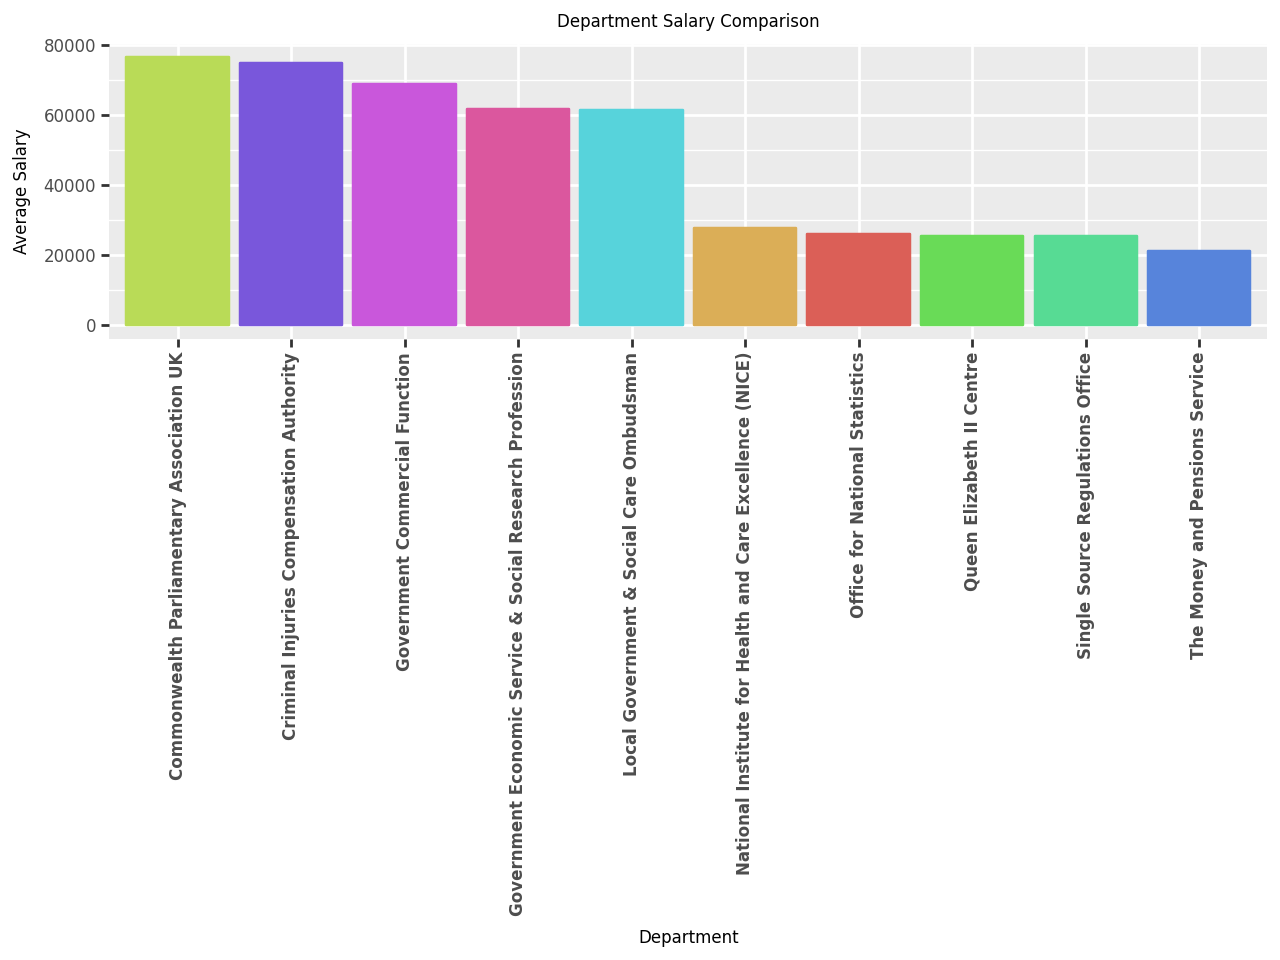

In [106]:
df['salary_int'] = df['salary'].str.replace(',','')
df['salary_int'] = df['salary_int'].astype(float)
df['week_commencing'] = df['scraped_date_date'].dt.to_period('W').dt.start_time
df['salary_int'].describe()
daily_salary = df[['week_commencing','salary_int','department','location']].groupby(['week_commencing','salary_int','department','location']).mean().reset_index()
department_salary = df[['salary_int','department']].groupby('department').mean()
department_salary = pd.concat([department_salary.nlargest(5, 'salary_int').reset_index(),department_salary.nsmallest(5, 'salary_int').reset_index()], axis=0, ignore_index=True).sort_values('salary_int', ascending=False)

plot = (
    ggplot(department_salary, aes(x=sorted(department_salary['department']), y='salary_int', color='department', fill='department'))
    + geom_col()
    + labs(title='Department Salary Comparison', x='Department', y='Average Salary')
    + theme(axis_text_x=element_text(angle=90, face='bold'))
    + theme(legend_position='none')
    + theme(axis_text_x=element_text(size=6))
    + theme(axis_text_y=element_text(size=6))
    + theme(axis_title=element_text(size=6))
    + theme(plot_title=element_text(size=6))
)

#make plot size bigger
plot.save("department_salary.png", width=10, height=10, units='in', dpi=300)
plot